# The K-Means clustering algorithm
Two version are presented here.   The first is Python Numpy operators and the second is using Googles Tensorflow.   The speedup results at the end are based on a 16-core virtual machine runing on a 16 core big memory server on Azure.

## note the data used is based on a simple anular array of points.   
This set has no natural clustering so by picking for starting points it will cluster it into four segments as shown below.  pick another four points and you will get a different set of segments.   also note that a bad choice for one point may give it no cluster and an error will happen.

In [1]:
%matplotlib inline
import numpy as np
import tensorflow as tf
import random
import matplotlib.pyplot as plt
from numpy import linalg as la
import time

In [2]:

#X is an array of N points in the plane
N = 1000 #  tested up to size 100000000
X = np.zeros(shape=(N,2))
for i in range(N):
    theta = 2*3.1417*random.random()
    dispx = 0.2*(random.random()-0.5)
    dispy = 0.2*(random.random()-0.5)
    X[i][0] = np.cos(theta)+dispx
    X[i][1] = np.sin(theta)+dispy

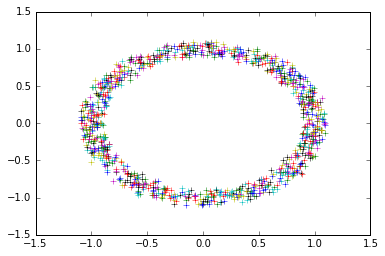

In [3]:
for x in X[:1000]:
    plt.plot(x[0],x[1], '+')

In [4]:
k = 4
kPoints0 = [[2., 1.], [0., 2.], [-1., 0], [0,-1.]]
oldpts = kPoints0
eps = 0.1

In [5]:
Xtrans = X.transpose()

In [6]:
def distance(P, Y):
    best = []
    for p in P:
        far = 100.0
        isave = -1
        for i in range(k):
            q = p-Y[i]
            d = np.vdot(q,q)
            if d < far:
                far = d
                isave = i
        best.extend([isave])
    return best
            

In [7]:
def ndist(P,Y):
    z = np.zeros([k,N])
    for i in range(k):
        w =P-Y[i]
        q = (w*w).transpose()
        z[:][i]= q[0]+q[1]
    return np.argmin(z,0)

In [8]:
#ndist(X, kPoints0)

In [9]:
def comperr(x,y):
    err = 0.0
    for i in range(len(x)):
        err += (x[i][0]-y[i][0])*(x[i][0]-y[i][0])+ (x[i][1]-y[i][1])*(x[i][1]-y[i][1])
    print err

In [10]:
def fun(x,y):
    if x == y:
        return 1
    return 0

In [11]:
t1 = time.time()
for i in range(20):
    oldpts = kPoints0
    dist = ndist(X, kPoints0)
    #v = [[(1,0)[d==j] for d in dist] for j in range(k)]
    #print v
    v = [[fun(d,j) for d in dist] for j in range(k)]
    sums = [np.sum(v[i]) for i in range(k)]
    sumx = [[np.sum(v[i]*(Xtrans[j]))/sums[i] for i in range(k)] for j in range(2)]
    kPoints0 = np.array(sumx).transpose()
    comperr(kPoints0,oldpts)

tser = time.time()-t1

2.99392800827
0.0743320903535
0.0181392500438
0.00432869535546
0.000846269722972
6.85772533491e-05
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0


In [12]:
kPoints0

array([[ 0.89359708,  0.1580515 ],
       [-0.08215614,  0.90982786],
       [-0.90416571, -0.0175881 ],
       [ 0.11347053, -0.87180547]])

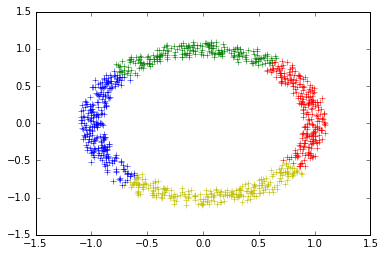

In [13]:
col = ['r+','g+','b+','y+']
i = 0
for x in X[:1000]:
    plt.plot(x[0],x[1], col[dist[i]])
    i +=1

In [14]:
Xv = tf.constant(X, name="point")

In [15]:
sess = tf.InteractiveSession()

In [16]:
kPoints = [[2., 1.], [0., 2.], [-1., 0], [0,-1.]]
dones = tf.fill([N,2], np.float64(1.))

In [17]:
centroids = tf.Variable(kPoints, name="centroids")
oldcents = tf.Variable(kPoints)
initvals = tf.constant(kPoints, tf.float64)
myarray = tf.Variable( tf.constant(1.0, shape = [2,3]))

In [18]:
init =tf.initialize_all_variables()
sess.run(init)

In [19]:
t1 = time.time()
centroids = initvals
for i in range(20):
    oldcents = centroids
    norms = []
    # for each point compute the squared of the norm of the 
    # distance to each of the k centroids
    for pts in kPoints:
        diff =  Xv-pts
        norms.extend([tf.reduce_sum(diff*diff, 1, name = "norms")])
    #convert the list of norm tensors to a single big tensor (each row is a list element)
    four = tf.concat(0, [norm for norm in norms])
    blocked = tf.reshape(four, [k, N], name="blockednorms")
    #find the index of the closest centroid
    mins = tf.argmin(blocked, 0, name="mins")
    #compute the new centroids as the mean of the points nearest
    sums = tf.unsorted_segment_sum(Xv, mins, k)
    totals = tf.unsorted_segment_sum(dones, mins, k, name="sums")
    centroids = tf.div(sums,totals, name = "newcents")
    #print centroids
    #print "----------"
    #print oldcents
    leap = centroids-oldcents
    #print leap.eval()
    accuracy = tf.reduce_mean(leap*leap, name="accuracy")
    #print accuracy
    print np.sqrt(accuracy.eval())
    kPoints = centroids.eval()
ttensor = time.time()-t1

0.61175240174
0.0963924856728
0.0476172894596
0.0232612751033
0.0102851210674
0.00292782456248
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0


In [20]:
kPoints

array([[ 0.89359708,  0.1580515 ],
       [-0.08215614,  0.90982786],
       [-0.90416571, -0.0175881 ],
       [ 0.11347053, -0.87180547]])

In [21]:
kPoints0

array([[ 0.89359708,  0.1580515 ],
       [-0.08215614,  0.90982786],
       [-0.90416571, -0.0175881 ],
       [ 0.11347053, -0.87180547]])

In [22]:
print "time ser = "+ str(tser)+ " time for tensor = "+str(ttensor)+ " ratio = " +str(tser/ttensor)

time ser = 0.0812890529633 time for tensor = 1.46450591087 ratio = 0.0555061282851


N = 100,000,000 time ser = 6240.6399138 time for tensor = 433.213545084 ratio = 14.4054588888

N = 10,000,000 time ser = 650.521790981 time for tensor = 48.1168851852 ratio = 13.5196155877

N - 1,000,000 time ser = 58.0978200436 time for tensor = 6.33883595467 ratio = 9.1653768072


N - 100,000 time ser = 5.850659132 time for tensor = 2.29915714264 ratio = 2.54469736909

N = 10,000 time ser = 0.657440900803 time for tensor = 1.7088739872 ratio = 0.384721697286


In [23]:
mynumpy =myarray.eval()
print(mynumpy)

[[ 1.  1.  1.]
 [ 1.  1.  1.]]
